# Planar Data Classification with Shallow Neural Networks

In [122]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

## Introduction

In this notebook, you will build a **`2-layer Neural Network`** from scratch to perform a **binary classification** task with **non-linearly seperatable** data.

## Import Data

To demonstrate the power of **Neural Networks** compares to other linear models (e.g. **Logistic Regression**), we will generate some **non-linearly seperatable** data with **binary classes**.

In this notebook, we will generate a set of **`planar data`** which looks like a **flower** in shape. Some of the data points are **red** (label $y=0$) and some are **blue** (label $y=1$). 

Our goal is to train a model that can **define regions** as either red or blue.

<div>
<img src="Images/13.png\" width="400"/>
</div>

In [127]:
def generate_planar_data():
    '''
    Function to generate a set of labelled planar data with size m=400 and dimension n=2.
    '''
    np.random.seed(1)
    m = 400          #number of examples
    N = int(m/2)     #number of points per class
    D = 2            #dimensionality
    a = 4            #maximum ray of the flower
    X = np.zeros((m,D))                   #data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8')    #labels vector (0 for red, 1 for blue)
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2    #theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2                       #radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    X, Y = X.T, Y.T
    return X, Y

Shape of X:  (2, 400)
Shape of y:  (1, 400)


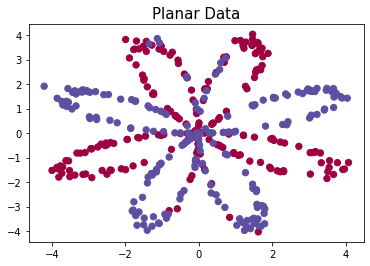

In [129]:
X, Y = generate_planar_data()

print('Shape of X: ', X.shape)
print('Shape of y: ', Y.shape)

plt.scatter(X[0,:], X[1,:], c=Y, s=40, cmap=plt.cm.Spectral)
plt.title('Planar Data', fontsize=15)
plt.show()

## Logistic Regression

Let's first train a **`Logistic Regression`** model and see how it performs:

In [123]:
lr = LogisticRegression()
lr.fit(X.T, Y[0].T)

LogisticRegression()

In [130]:
def plot_decision_boundary(model, X, y):
    '''
    Function to plot the decision boundary defined by the model.
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

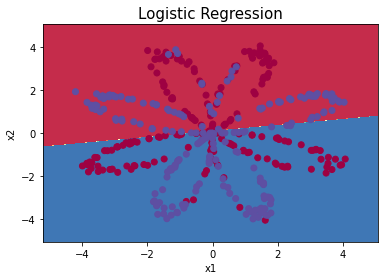

In [131]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lr, X, Y)
plt.title("Logistic Regression", fontsize=15)
plt.show()

In [126]:
y_pred_lr = lr.predict(X.T)
accuracy_lr = np.sum(y_pred_lr == Y) / Y.shape[1]
print (f'Accuracy of Logistic Regression: {100*accuracy_lr}%', )

Accuracy of Logistic Regression: 47.0%


## 2-Layer Neural Networks

Let's now construct a **`2-layer Neural Network`** as shown below:

<div>
<img src="Images/11.png\" width="600"/>
</div>

The formulas used to calcualte the **derivatives** in **back propagation** are:

<div>
<img src="Images/12.png\" width="400"/>
</div>

In [84]:
class NN:
    
    def __init__(self, X_train, y_train, n_h, learning_rate, threshold, n_iter=10000):
        self.X_train = X_train
        self.y_train = y_train
        self.n_x = X_train.shape[0]       #size of the input layer
        self.n_h = n_h                    #size of the hidden layer
        self.n_y = y_train.shape[0]       #size of the output layer
        self.threshold = threshold                #threshold for making predictions
        self.n_iter = n_iter                      #number of iterations for gradient descent
        self.learning_rate = learning_rate        #learning rate for gradient descent
        self.W1 = np.random.randn(self.n_h, self.n_x) * 0.01       #weights of the hidden layer
        self.b1 = np.zeros((self.n_h, 1))                          #bias of the hidden layer
        self.W2 = np.random.randn(self.n_y, self.n_h) * 0.01       #weights of the output layer
        self.b2 = np.zeros((self.n_y, 1))                          #bias of the output layer
        self.J = np.zeros((1,n_iter))
    
    def accuracy(self, y_true, y_pred):
        accuracy = np.sum(y_true==y_pred) / y_true.shape[1]            
        return accuracy
    
    def log_loss(self, y_true, y_pred):
        m = y_true.shape[1]                                            #number of samples
        L = y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)        #loss on each sample
        J = -np.sum(L) / m                                             #the overall cost
        J = float(np.squeeze(J))                                       #make sure the cost is a float value
        return L, J
    
    def forward_propagate(self, X, y):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = 1 / (1+np.exp(-Z2))
        L, J = self.log_loss(y, A2)               
        return Z1, A1, Z2, A2, J
    
    def back_propagate(self, X, y):
        m = X.shape[1]
        Z1, A1, Z2, A2, J = self.forward_propagate(X, y)
        dZ2 = A2 - y
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dZ1 = np.dot(self.W2.T, dZ2) * (1-np.power(A1,2))
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m
        return dW2, db2, dW1, db1, J
    
    def gradient_descent(self):
        dW2, db2, dW1, db1, J = self.back_propagate(self.X_train, self.y_train)
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        return J
        
    def train(self):
        start = time()
        for i in range(self.n_iter):
            J = self.gradient_descent()
            self.J[0,i] = J
            if i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, J))
        end = time()
        print(f'Model successfully trained over {self.n_iter} iterations using {round(end-start, 3)} seconds.')
        plt.figure(figsize=(8,6))
        plt.plot(self.J[0])
        plt.title('Gradient Descent', fontsize=20)
        plt.ylabel('Cost', fontsize=15)
        plt.xlabel('Iterations', fontsize=15)
        plt.show()
          
    def predict(self, X, y):
        _, _, _, A, _ = self.forward_propagate(X, y)    #make predictions through forward propagation
        y_pred = A.copy()
        y_pred[y_pred>=self.threshold] = 1              #compares the predicted probabilities to the threshold
        y_pred[y_pred<self.threshold] = 0
        error = 1 - self.accuracy(y, y_pred)
        return y_pred, error

Cost after iteration 0: 0.693157
Cost after iteration 1000: 0.288028
Cost after iteration 2000: 0.274610
Cost after iteration 3000: 0.267212
Cost after iteration 4000: 0.262585
Cost after iteration 5000: 0.259430
Cost after iteration 6000: 0.257154
Cost after iteration 7000: 0.255441
Cost after iteration 8000: 0.254107
Cost after iteration 9000: 0.253038
Model successfully trained over 10000 iterations using 1.221 seconds.


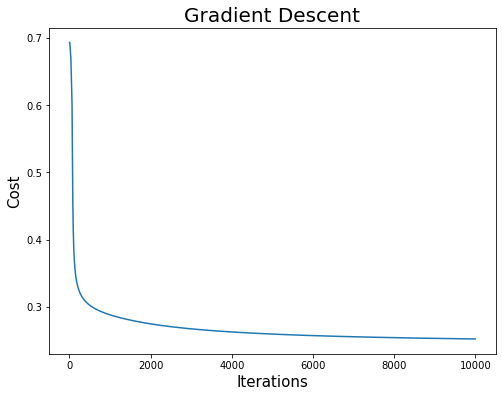

In [85]:
#we first initialize the parameters
n_h = 4
threshold = 0.5
learning_rate = 1.2

#we need to create a logistic regression model
nn = NN(X, Y, n_h, learning_rate, threshold)

#then, we train the model
nn.train()

In [86]:
y_pred_train, train_error = nn.predict(X, Y)

print(f'Training error: {100*round(train_error,4)}%')

Training error: 8.75%


In [111]:
def plot_decision_boundary_NN(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z, _ = model.predict(np.c_[xx.ravel(), yy.ravel()].T, np.zeros((1,np.c_[xx.ravel(), yy.ravel()].shape[0])))
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

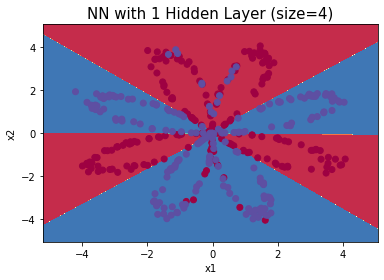

In [114]:
plot_decision_boundary_NN(nn, X, y)
plt.title("NN with 1 Hidden Layer (size=4)", fontsize=15)
plt.show()